In [1]:
import os
import numpy as np
import h5py

from PIL import Image, ImageOps

Decompress the compressed file containing the IM2LATEX handwritten dataset (obtained from https://im2markup.yuntiandeng.com/data/)

In [2]:
DATA_FOLDER = "IM2LATEX-100K-HANDWRITTEN"
DATA_FILE = DATA_FOLDER + ".tgz"
if not os.path.exists(DATA_FOLDER):
    !tar -xzf {DATA_FILE}
else:
    print("Handwritten folder already decompressed.")

Handwritten folder already decompressed.


In [3]:
IMAGES_FOLDER = os.path.join(DATA_FOLDER, "images")
image_filenames = os.listdir(IMAGES_FOLDER)
total_images_all = 99552
assert 99552 == len(image_filenames)

View an image from the dataset:

7370.png


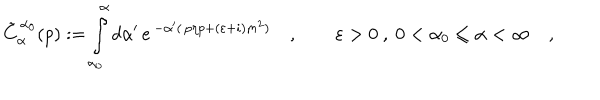

In [4]:
rand_img_filename = np.random.choice(image_filenames)
print(rand_img_filename)
Image.open(os.path.join(IMAGES_FOLDER, rand_img_filename))

Tokenize and normalize the LaTeX formulas, if they haven't already. There will be some errors thrown, since not all formulas in the dataset can be properly parsed. That is okay, those examples are thrown out.

In [5]:
formulas_file = os.path.join(DATA_FOLDER, "formulas.lst")
formulas_norm_file = os.path.join(DATA_FOLDER, "formulas_norm.lst")
if not os.path.exists(formulas_norm_file):
    !python "scripts/preprocessing/preprocess_formulas.py" --mode normalize --input-file {formulas_file} --output-file {formulas_norm_file}
else:
    print("Formulas already normalized.")

Formulas already normalized.


Filter out examples whose images are too big or whose formulas have grammar errors

In [6]:
max_width = 500
max_height = 160
max_tokens = 150

for dataset_type in ("train", "val", "test"):
    dataset_filename = os.path.join(DATA_FOLDER, dataset_type)
    unfiltered_filename = dataset_filename + ".lst"
    filtered_filename = dataset_filename + "_filtered.lst"
    if not os.path.exists(filtered_filename):
        !python scripts/preprocessing/preprocess_filter.py --filter --image-dir {IMAGES_FOLDER} --label-path {formulas_norm_file} --data-path {unfiltered_filename} --output-path {filtered_filename} --max-width {max_width} --max-height {max_height} --max-tokens {max_tokens}
    else:
        print(f"{dataset_type} already filtered.")

train already filtered.
val already filtered.
test already filtered.


Generate the vocabulary for the training set:

In [7]:
train_filter_filename = os.path.join(DATA_FOLDER, "train_filtered.lst")
vocab_file = os.path.join(DATA_FOLDER, "latex_vocab.txt")
if not os.path.exists(vocab_file):
    !python scripts/preprocessing/generate_latex_vocab.py --data-path {train_filter_filename} --label-path {formulas_norm_file} --output-file {vocab_file}
else:
    print("vocab file already generated")

vocab file already generated


And then get a mapping of those words to a unique number, and save these mappings to a file:

In [2]:
PROCESSED_DATA_FOLDER = "data"
if not os.path.exists(PROCESSED_DATA_FOLDER):
    os.makedirs(PROCESSED_DATA_FOLDER)

In [8]:
with open(vocab_file, "r") as vf:
    raw_vocab_words = vf.read().split("\n")
    vocab_words = ["<s>", "<pad>", "</s>", "<unk>", "<mask>"] + raw_vocab_words
    word_to_idx = dict(zip(vocab_words, range(len(vocab_words))))
    idx_to_word = dict(zip(range(len(vocab_words)), vocab_words))

vocab_to_idx_file = os.path.join(PROCESSED_DATA_FOLDER, "vocab_to_idx.txt")
with open(vocab_to_idx_file, "w+") as f:
    print("\n".join([f"{word} {idx}" for word, idx in word_to_idx.items()]), end="", file=f)

print(vocab_words[:20])

['<s>', '<pad>', '</s>', '<unk>', '<mask>', '!', '"', '&', "'", '(', ')', '*', '+', ',', '-', '--', '---', '.', '/', '0']


Get every normalized formula, split by token:

In [9]:
with open(formulas_norm_file, "r") as ff:
    text_formulas = ff.read().split("\n")[:-1]
token_formulas = [l.split(" ") for l in text_formulas]

for i in range(10):
    print(token_formulas[i])

['d', 's', '^', '{', '2', '}', '=', '(', '1', '-', '{', '\\frac', '{', 'q', 'c', 'o', 's', '\\theta', '}', '{', 'r', '}', '}', ')', '^', '{', '\\frac', '{', '2', '}', '{', '1', '+', '\\alpha', '^', '{', '2', '}', '}', '}', '\\lbrace', 'd', 'r', '^', '{', '2', '}', '+', 'r', '^', '{', '2', '}', 'd', '\\theta', '^', '{', '2', '}', '+', 'r', '^', '{', '2', '}', 's', 'i', 'n', '^', '{', '2', '}', '\\theta', 'd', '\\varphi', '^', '{', '2', '}', '\\rbrace', '-', '{', '\\frac', '{', 'd', 't', '^', '{', '2', '}', '}', '{', '(', '1', '-', '{', '\\frac', '{', 'q', 'c', 'o', 's', '\\theta', '}', '{', 'r', '}', '}', ')', '^', '{', '\\frac', '{', '2', '}', '{', '1', '+', '\\alpha', '^', '{', '2', '}', '}', '}', '}', '}', '\\,', '.']
['\\widetilde', '\\gamma', '_', '{', '\\mathrm', '{', 'h', 'o', 'p', 'f', '}', '}', '\\simeq', '\\sum', '_', '{', 'n', '>', '0', '}', '\\widetilde', '{', 'G', '}', '_', '{', 'n', '}', '{', '\\frac', '{', '(', '-', 'a', ')', '^', '{', 'n', '}', '}', '{', '2', '^', '{', '

Get, for each split in the dataset, each image name that corresponds to a valid image and valid formula:

In [12]:
valid_image_names = {t: set() for t in ("train", "val", "test")}
for dataset_type in valid_image_names.keys():
    dataset_info = os.path.join(DATA_FOLDER, dataset_type + "_filtered.lst")
    with open(dataset_info, "r") as dsf:
        lines = dsf.read().split("\n")
    valid_image_names[dataset_type].update([l.split(" ")[0] for l in lines if len(l) > 0])

Turn the images, tokens, etc. into a dictionary with all the dataset information:

In [18]:
start_plus_end = 2
dataset = {}
for dataset_type in ("train", "val", "test"):
    # get mapping of image filename <-> list-of-token-sequeneces index
    dataset_info = os.path.join(DATA_FOLDER, dataset_type + "_filtered.lst")
    with open(dataset_info, "r") as dsf:
        lines = dsf.read().split("\n")
    img_fn_and_idx = [l.split(" ") for l in lines if len(l) > 0]
    img_fn_to_idx = {l[0]: int(l[1]) for l in img_fn_and_idx}
    
    shape_to_imgs = dict()
    shape_to_img_nums = dict()
    shape_to_formula_idxs = dict()
    shape_to_token_nums = dict()
    shape_to_counts = dict()

    for img_fn in valid_image_names[dataset_type]:
        # get grayscale image and its shape
        formula_idx = img_fn_to_idx[img_fn]
        img = Image.open(os.path.join(IMAGES_FOLDER, img_fn), "r")
        img_gray = ImageOps.grayscale(img)
        img_arr_orig = np.asarray(img_gray)
        img_arr = np.ones((img_arr_orig.shape[0], img_arr_orig.shape[1]), dtype=np.uint8)
        img_arr[:img_arr_orig.shape[0], :img_arr_orig.shape[1]] = img_arr_orig
        shape = img_arr.shape
        
        if shape not in shape_to_imgs:
            shape_to_imgs[shape] = []
            shape_to_img_nums[shape] = []
            shape_to_formula_idxs[shape] = []
            shape_to_token_nums[shape] = []
        
        # group this image and info about it with others of the same shape
        shape_to_imgs[shape].append(img_arr)
        shape_to_img_nums[shape].append(int(img_fn[:-4]))
        shape_to_formula_idxs[shape].append(formula_idx)

        # create token num numpy array
        token_nums = word_to_idx["<pad>"] \
            * np.ones((max_tokens + start_plus_end,), dtype=np.int16)
        token_nums[0] = word_to_idx["<s>"]
        token_formula = token_formulas[formula_idx]
        for j, token in enumerate(token_formula):
            token_nums[j + 1] = word_to_idx.get(token, word_to_idx["<unk>"])
        token_nums[j + 2] = word_to_idx["</s>"]
        shape_to_token_nums[shape].append(token_nums)

    # convert list of numpy arrays to numpy array
    for shape in shape_to_imgs.keys():
        shape_to_imgs[shape] = np.array(shape_to_imgs[shape])
        shape_to_img_nums[shape] = np.array(shape_to_img_nums[shape])
        shape_to_formula_idxs[shape] = np.array(shape_to_formula_idxs[shape])
        shape_to_token_nums[shape] = np.array(shape_to_token_nums[shape])
        shape_to_counts[shape] = shape_to_imgs[shape].shape[0]

    # for more predictable example indexing
    shape_orderings = np.array(sorted(shape_to_imgs.keys(), key=lambda hw: hw[0] * hw[1]))

    dataset[dataset_type] = {
        "N": len(valid_image_names[dataset_type]),
        "max_width": max_width,
        "max_height": max_height,
        "max_tokens": max_tokens + start_plus_end,
        "shape_to_imgs": shape_to_imgs,
        "shape_to_img_nums": shape_to_img_nums,
        "shape_to_formula_idxs": shape_to_formula_idxs,
        "shape_to_token_nums": shape_to_token_nums,
        "shape_to_counts": shape_to_counts,
        "shape_orderings": shape_orderings,
    }


Get a random training example, to make sure the tokens and the image correspond to each other:

In [19]:
def get_example(dataset_type, example_num):
    dataset_split = dataset[dataset_type]
    remaining = example_num
    for shape_np in dataset_split["shape_orderings"]:
        shape = tuple(shape_np)
        shape_count = dataset_split["shape_to_counts"][shape]
        if remaining - shape_count < 0:
            break
        remaining -= shape_count
    
    token_nums = dataset_split["shape_to_token_nums"][shape][remaining]
    tokens = [idx_to_word[token_num] for token_num in token_nums]

    return {
        "img": dataset_split["shape_to_imgs"][shape][remaining],
        "img_num": dataset_split["shape_to_img_nums"][shape][remaining],
        "formula_idx": dataset_split["shape_to_formula_idxs"][shape][remaining],
        "token_nums": token_nums,
        "tokens": tokens
    }

36447 ['<s>', '\\frac', '{', 'i', '}', '{', '2', '}', 'h', '_', '{', '\\mu', '}', '\\frac', '{', '\\partial', '}', '{', '\\partial', 'x', '_', '{', '\\mu', '}', '}', '\\int', 'd', '^', '{', '3', '}', 'y', '\\frac', '{', '\\rho', '(', '{', '\\bf', 'y', '}', ')', '}', '{', '|', '{', '\\bf', 'x', '}', '-', '{', '\\bf', 'y', '}', '|', '}', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

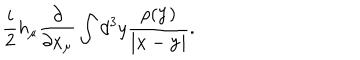

In [26]:
rand_example_num = int(np.random.rand() * dataset["train"]["N"])
example = get_example("train", rand_example_num)
print(rand_example_num, example["tokens"])
print(rand_example_num, example["token_nums"])
Image.fromarray(example["img"], mode="L")

Save the dataset to an H5 file. The saved file will be pretty large (~2.4 GB), but, zipping it will reduce its size significantly (~180 MB). Be sure to zip it if you send it elsewhere!

In [27]:
save_to_filename = os.path.join(PROCESSED_DATA_FOLDER, "handwritten_dataset.h5")
with h5py.File(save_to_filename, "w") as f:
    for dataset_type in ("train", "val", "test"):
        dataset_split = dataset[dataset_type]
        group = f.create_group(dataset_type, track_order=True)
        for attr in ("N", "max_height", "max_width", "max_tokens", "shape_orderings"):
            group.attrs[attr] = dataset_split[attr]

        for shape_np in shape_orderings:
            shape = tuple(shape_np)
            shape_group = group.create_group(f"{shape[0]}x{shape[1]}")
            shape_group.attrs["count"] = dataset_split["shape_to_counts"][shape]
        
            for info_name in ("imgs", "img_nums", "formula_idxs", "token_nums"):
                info_value = dataset_split[f"shape_to_{info_name}"][shape]
                subdset = shape_group.create_dataset(info_name, info_value.shape, str(info_value.dtype))
                subdset[()] = info_value